In [1]:
import requests
from PIL import Image, ImageDraw
import torch
from transformers import OwlViTProcessor, OwlViTForObjectDetection
from pathlib import Path
from torchvision.ops import nms
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=125):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

### Load Model

In [3]:
device = torch.device('cuda:4')

processor = OwlViTProcessor.from_pretrained("google/owlvit-large-patch14")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-large-patch14")
model.eval;
model.to(device);

# print all named model parameters
for name, param in model.named_parameters():
    print(name, param.shape)


owlvit.logit_scale torch.Size([])
owlvit.text_model.embeddings.token_embedding.weight torch.Size([49408, 768])
owlvit.text_model.embeddings.position_embedding.weight torch.Size([16, 768])
owlvit.text_model.encoder.layers.0.self_attn.k_proj.weight torch.Size([768, 768])
owlvit.text_model.encoder.layers.0.self_attn.k_proj.bias torch.Size([768])
owlvit.text_model.encoder.layers.0.self_attn.v_proj.weight torch.Size([768, 768])
owlvit.text_model.encoder.layers.0.self_attn.v_proj.bias torch.Size([768])
owlvit.text_model.encoder.layers.0.self_attn.q_proj.weight torch.Size([768, 768])
owlvit.text_model.encoder.layers.0.self_attn.q_proj.bias torch.Size([768])
owlvit.text_model.encoder.layers.0.self_attn.out_proj.weight torch.Size([768, 768])
owlvit.text_model.encoder.layers.0.self_attn.out_proj.bias torch.Size([768])
owlvit.text_model.encoder.layers.0.layer_norm1.weight torch.Size([768])
owlvit.text_model.encoder.layers.0.layer_norm1.bias torch.Size([768])
owlvit.text_model.encoder.layers.0.mlp

### Detect Objects

In [4]:
n = 0

In [22]:
# image_path = "/data/mwoedlinger/code/sustainibility-hackathon/sample_data2/data/image0000004.jpg"
# image_path = "/data/mwoedlinger/code/download-removebg-preview.png"
# image_path = "/data/mwoedlinger/code/image19-removebg-preview.png"
# image_path = "/data/mburges/for_matthias/images_hackathon/image19.jpg"
images = [img for img in Path('/data/mburges/for_matthias/images_hackathon').iterdir()]

# Load image
image_path = images[n]
image = Image.open(image_path).convert("RGB")
#texts = [["object", "can", "bottle"]]
texts = [["object", "Can: Sealed cylindrical metal container", "Bottle: Narrow-necked liquid storage container"]]
inputs = processor(text=texts, images=image, return_tensors="pt")

n += 1

Detected Can: Sealed cylindrical metal container with confidence 0.492 at location [1206.84, 117.86, 1602.21, 477.48]
Detected Bottle: Narrow-necked liquid storage container with confidence 0.203 at location [1.42, 135.94, 373.15, 545.02]
Detected Can: Sealed cylindrical metal container with confidence 0.111 at location [357.68, 245.21, 698.92, 565.95]
Detected Can: Sealed cylindrical metal container with confidence 0.115 at location [-16.46, 118.03, 718.89, 572.45]
Detected Can: Sealed cylindrical metal container with confidence 0.371 at location [355.1, 233.78, 735.76, 561.71]
Detected Can: Sealed cylindrical metal container with confidence 0.192 at location [1211.23, 113.07, 1612.76, 478.5]
Detected Can: Sealed cylindrical metal container with confidence 0.168 at location [353.46, 227.05, 725.37, 564.18]
Detected Can: Sealed cylindrical metal container with confidence 0.135 at location [-24.51, 101.27, 1869.27, 1093.74]
Detected object with confidence 0.179 at location [-4.4, 77.13,

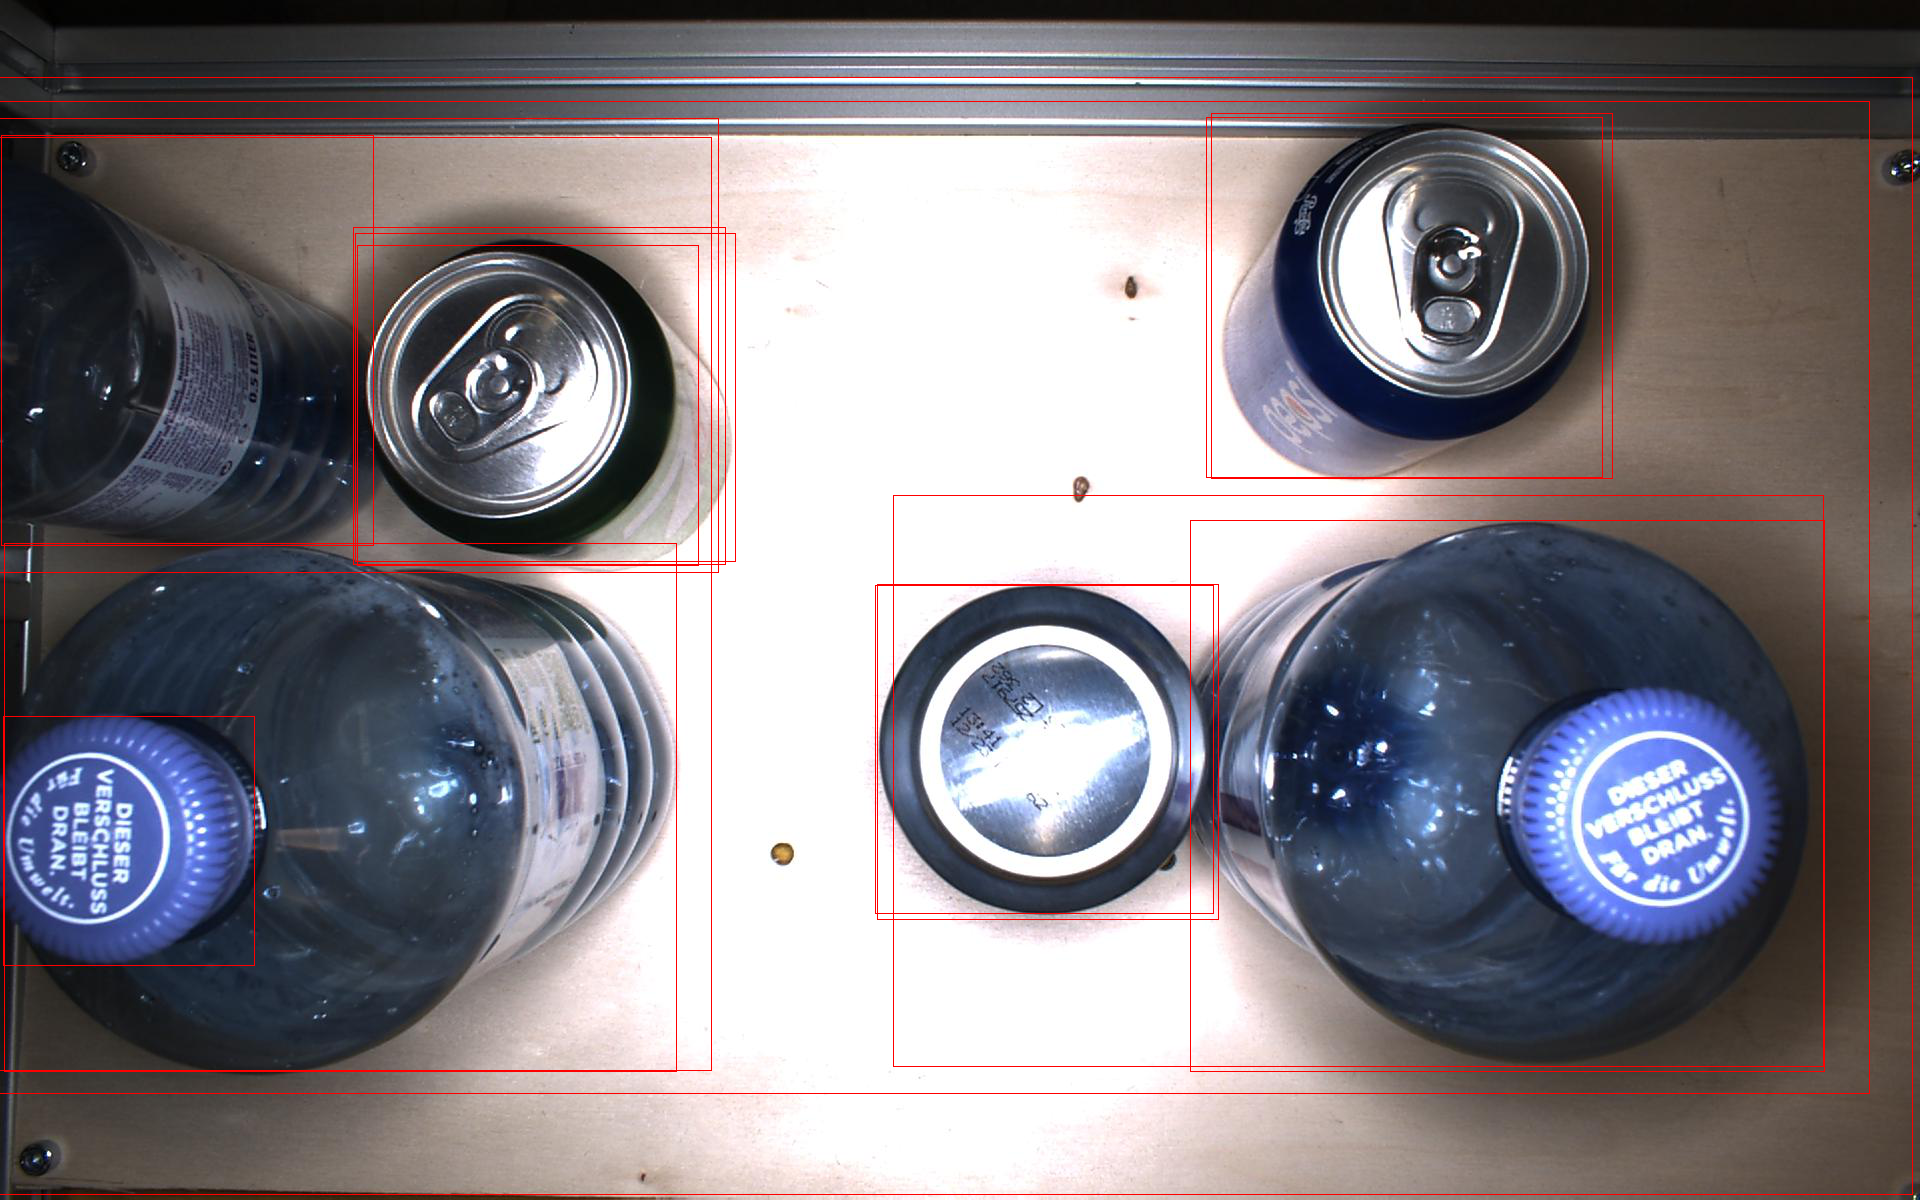

In [23]:
with torch.no_grad():
    outputs = model(**inputs.to(device))

# print(outputs.keys())
# for k, v in outputs.items():
#     print(k, v.shape)
# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.size[::-1]]).to(device)
# Convert outputs (bounding boxes and class logits) to COCO API
results = processor.post_process(outputs=outputs, target_sizes=target_sizes)

i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

# Print detected objects and rescaled box coordinates
score_threshold = 0.1
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    if score >= score_threshold:
        print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")
        
# visualize results with pillow
draw = ImageDraw.Draw(image)
for i in range(len(boxes)):
    if scores[i] > 0.1:
        draw.rectangle(((boxes[i][0], boxes[i][1]), (boxes[i][2], boxes[i][3])), outline="red")
        #draw.text((boxes[i][0], boxes[i][1]), str(labels[i]) + " " + str(scores[i]), fill="red")
image.show()

### Non-maximum suppression

In [24]:
boxes_filtered = boxes[scores > 0.1]
scores_filtered = scores[scores > 0.1]
labels_filtered = labels[scores > 0.1]
embeddings_filtered = outputs['class_embeds'][0, scores > 0.1]

print("boxes", boxes.shape)

for k, val in outputs.items():
    if k not in {"text_model_output", "vision_model_output"}:
        print(f"{k}: shape of {val.shape}")

boxes torch.Size([3600, 4])
logits: shape of torch.Size([1, 3600, 3])
pred_boxes: shape of torch.Size([1, 3600, 4])
text_embeds: shape of torch.Size([1, 3, 768])
image_embeds: shape of torch.Size([1, 60, 60, 1024])
class_embeds: shape of torch.Size([1, 3600, 768])


In [25]:
nms_out = nms(boxes_filtered, scores_filtered, iou_threshold=0.1)

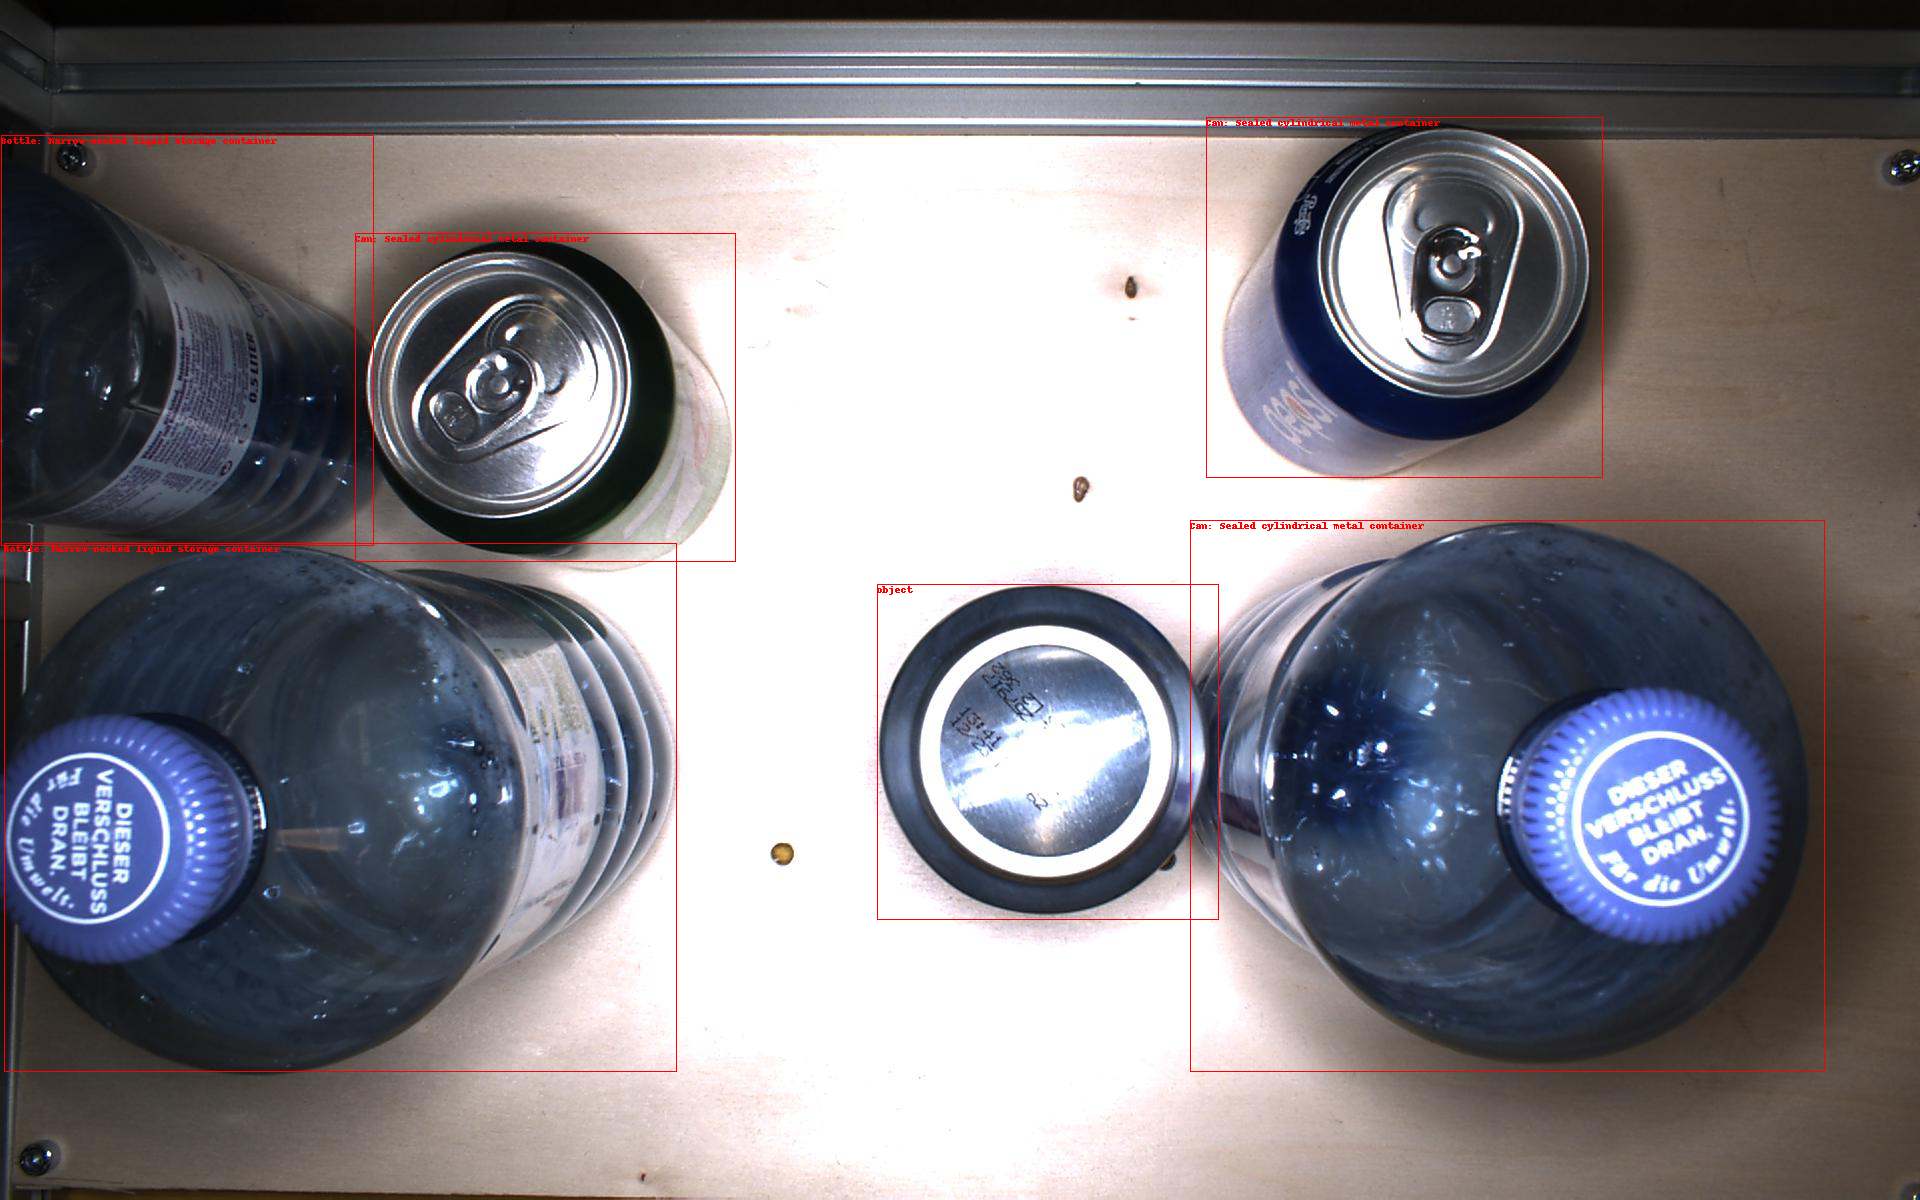

boxes_nms torch.Size([6, 4])
embeddings_nms torch.Size([6, 768])
labels_nms ['Can: Sealed cylindrical metal container', 'Can: Sealed cylindrical metal container', 'object', 'Can: Sealed cylindrical metal container', 'Bottle: Narrow-necked liquid storage container', 'Bottle: Narrow-necked liquid storage container']
torch.Size([768]) torch.Size([6, 768])
tensor([1.0000, 0.9283, 0.5951, 0.7128, 0.6908, 0.7319], device='cuda:4')
torch.Size([768]) torch.Size([6, 768])
tensor([0.9283, 1.0000, 0.6087, 0.7141, 0.7271, 0.7735], device='cuda:4')
torch.Size([768]) torch.Size([6, 768])
tensor([0.5951, 0.6087, 1.0000, 0.7578, 0.5850, 0.4405], device='cuda:4')
torch.Size([768]) torch.Size([6, 768])
tensor([0.7128, 0.7141, 0.7578, 1.0000, 0.8980, 0.7404], device='cuda:4')
torch.Size([768]) torch.Size([6, 768])
tensor([0.6908, 0.7271, 0.5850, 0.8980, 1.0000, 0.8773], device='cuda:4')
torch.Size([768]) torch.Size([6, 768])
tensor([0.7319, 0.7735, 0.4405, 0.7404, 0.8773, 1.0000], device='cuda:4')


In [26]:
image_path = images[n-1]

# Load image
image = Image.open(image_path).convert("RGB")

# visualize results with pillow
draw = ImageDraw.Draw(image)
bounding_boxes = boxes_filtered[nms_out]
embeddings_nms = embeddings_filtered[nms_out]
labels_nms = labels_filtered[nms_out]

labels_in_image = []
for i in labels_nms:
    labels_in_image.append(text[i])

for i in range(len(bounding_boxes)):
    # label
    draw.text((bounding_boxes[i][0], bounding_boxes[i][1]), labels_in_image[i], fill="red")
    draw.rectangle(((bounding_boxes[i][0], bounding_boxes[i][1]), (bounding_boxes[i][2], bounding_boxes[i][3])), outline="red")
image.show()

#save image with just the date in the name
image_name = str(image_path).split("/")[-1]
image.save("/caa/Homes01/mburges/viennaup23-hackathon-recycling/backend/example_images/{}".format(image_name))

print("boxes_nms", bounding_boxes.shape)
print("embeddings_nms", embeddings_nms.shape)
print("labels_nms", labels_in_image)

# print cosine similarity between all pairs of bounding boxes torch
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
for emb in embeddings_nms:
    print(emb.shape, embeddings_nms.shape)
    print(cos(emb.unsqueeze(0), embeddings_nms))
